In [1]:
import numpy as np
import os
from scipy import stats
import scipy.integrate as integrate
import tensorflow as tf

from mpl_toolkits.mplot3d import Axes3D  
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Patch
from matplotlib import rc
import matplotlib.font_manager
rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

np.random.seed(666)
eps = 1e-7

In [2]:
def sig(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(+0.1, 1)

In [3]:
# Empiric estimation of losses

N = 5 * 10**3
X = np.concatenate((bkgd.rvs(size = N), sgnl.rvs(size = N)))
y = np.concatenate((np.zeros(N), np.ones(N)))

def bce(a, b):
    XX = np.repeat(X, np.prod(np.shape(a))).reshape(X.shape + np.shape(a))
    yy = np.repeat(y, np.prod(np.shape(a))).reshape(y.shape + np.shape(a))
    y_hat = sig(a*XX + b)
    return 2 * -np.mean((yy) * np.log(y_hat + eps) + (1 - yy) * np.log(1 - y_hat + eps), axis = 0)

def mse(a, b):
    XX = np.repeat(X, np.prod(np.shape(a))).reshape(X.shape + np.shape(a))
    yy = np.repeat(y, np.prod(np.shape(a))).reshape(y.shape + np.shape(a))
    y_hat = sig(a*XX + b)
    return 2 * -np.mean((yy) * -(1 - y_hat)**2 + (1 - yy) * -(y_hat)**2, axis = 0)

def mse_p(a, b, p):
    XX = np.repeat(X, np.prod(np.shape(a))).reshape(X.shape + np.shape(a))
    yy = np.repeat(y, np.prod(np.shape(a))).reshape(y.shape + np.shape(a))
    y_hat = sig(a*XX + b) 
    return 2 * -np.mean((yy) * -(1 - y_hat)**p + (1 - yy) * -(y_hat)**p, axis = 0)

def mlc(a, b):
    XX = np.repeat(X, np.prod(np.shape(a))).reshape(X.shape + np.shape(a))
    yy = np.repeat(y, np.prod(np.shape(a))).reshape(y.shape + np.shape(a))
    y_hat = relu(a*XX + b)
    return 2 * -np.mean((yy) * np.log(y_hat + eps) + (1 - yy) * (1 - y_hat), axis = 0)

def exp_mlc(a, b):
    XX = np.repeat(X, np.prod(np.shape(a))).reshape(X.shape + np.shape(a))
    yy = np.repeat(y, np.prod(np.shape(a))).reshape(y.shape + np.shape(a))
    y_hat = relu(a*XX + b)
    return 2 * -np.mean((yy) * y_hat + (1 - yy) * (1 - np.exp(y_hat)), axis = 0)

def sqr(a, b):
    XX = np.repeat(X, np.prod(np.shape(a))).reshape(X.shape + np.shape(a))
    yy = np.repeat(y, np.prod(np.shape(a))).reshape(y.shape + np.shape(a))
    y_hat = relu(a*XX + b)
    return 2 * -np.mean((yy) * -(1 / (y_hat + eps)**0.5) + (1 - yy) * -(y_hat)**0.5, axis = 0)

def exp_sqr(a, b):
    XX = np.repeat(X, np.prod(np.shape(a))).reshape(X.shape + np.shape(a))
    yy = np.repeat(y, np.prod(np.shape(a))).reshape(y.shape + np.shape(a))
    y_hat = relu(a*XX + b)
    return 2 * -np.mean((yy) * -(1 / np.exp(y_hat)**0.5) + (1 - yy) * -(np.exp(y_hat))**0.5, axis = 0)

def sqr_r(a, b, r):
    XX = np.repeat(X, np.prod(np.shape(a))).reshape(X.shape + np.shape(a))
    yy = np.repeat(y, np.prod(np.shape(a))).reshape(y.shape + np.shape(a))
    y_hat = relu(a*XX + b)
    return 2 * -np.mean((yy) * -(1 / (y_hat + eps)**(r/2)) + (1 - yy) * -(y_hat)**(r/2), axis = 0) 

In [4]:
# Numerical estimation of losses

def nbce(a, b):
    g = lambda x: -(sgnl.pdf(x) * np.log(sig(a*x + b) + eps) + \
                    bkgd.pdf(x) * np.log(1 - sig(a*x + b) + eps) )
    return integrate.quad_vec(g, -np.inf, np.inf)[0]

def nmse(a, b):
    g = lambda x: -(sgnl.pdf(x) * -(1 - sig(a*x + b))**2 + \
                    bkgd.pdf(x) * -(sig(a*x + b)**2) )
    return integrate.quad_vec(g, -np.inf, np.inf)[0]

def nmlc(a, b):
    g = lambda x: -(sgnl.pdf(x) * np.log(relu(a*x + b) + eps) + \
                    bkgd.pdf(x) * (1 - relu(a*x + b)) )
    return integrate.quad_vec(g, -np.inf, np.inf)[0]

def nsqr(a, b):
    g = lambda x: -(sgnl.pdf(x) * -1 / (relu(a*x + b) + eps)**0.5 + \
                    bkgd.pdf(x) * -relu(a*x + b)**0.5 )
    return integrate.quad_vec(g, -np.inf, np.inf)[0]

In [149]:
def gridded(loss, g_min, g_max, f, n_splits):
    chunks = [None] * n_splits
    span = (g_max - g_min) / n_splits
    n_points = int( span / f)
    n_total = int( (g_max - g_min) / f )

    for i in range(n_splits - 1):
        chunks[i] = np.linspace(g_min + i * span, g_min + (i + 1) * span - f, n_points)
    chunks[n_splits - 1] = np.linspace(g_min + (n_splits - 1) * span, g_min + n_splits * span, n_points + 1)
    
    aa, bb = np.meshgrid(np.linspace(g_min, g_max, n_total + 1), np.linspace(g_min, g_max, n_total + 1))
    
    grids = [None] * n_splits**2
    for i in range(n_splits):
        for j in range(n_splits):
            grids[n_splits*i + j] = np.meshgrid(chunks[i], chunks[j])

    losses = [None] * n_splits**2
    for i in range(n_splits**2):
        print(i, end = ' ')
        losses[i] = loss(grids[i][0], grids[i][1])
    losses = np.hstack([np.vstack([losses[j] for j in range(i, i + n_splits)]) for i in range(0, n_splits**2, n_splits)])
    return losses, aa, bb

In [147]:
g_min = -3
g_max = 3
f = 0.01
n_splits = 10

chunks = [None] * n_splits
span = (g_max - g_min) / n_splits
n_points = int( span / f)

for i in range(n_splits - 1):
    chunks[i] = np.linspace(g_min + i * span, g_min + (i + 1) * span - f, n_points)
chunks[n_splits - 1] = np.linspace(g_min + (n_splits - 1) * span, g_min + n_splits * span, n_points + 1)

grids = [None] * n_splits**2
for i in range(n_splits):
    for j in range(n_splits):
        grids[n_splits*i + j] = np.meshgrid(chunks[i], chunks[j])

In [91]:
bces = [None] * n_splits**2
for i in range(n_splits**2):
    print(i, end = ' ')
    bces[i] = bce(grids[i][0], grids[i][1])

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [100]:
grids[0][0]

array([[-3.  , -2.99, -2.98, ..., -2.43, -2.42, -2.41],
       [-3.  , -2.99, -2.98, ..., -2.43, -2.42, -2.41],
       [-3.  , -2.99, -2.98, ..., -2.43, -2.42, -2.41],
       ...,
       [-3.  , -2.99, -2.98, ..., -2.43, -2.42, -2.41],
       [-3.  , -2.99, -2.98, ..., -2.43, -2.42, -2.41],
       [-3.  , -2.99, -2.98, ..., -2.43, -2.42, -2.41]])

In [101]:
grids[0][1]

array([[-3.  , -3.  , -3.  , ..., -3.  , -3.  , -3.  ],
       [-2.99, -2.99, -2.99, ..., -2.99, -2.99, -2.99],
       [-2.98, -2.98, -2.98, ..., -2.98, -2.98, -2.98],
       ...,
       [-2.43, -2.43, -2.43, ..., -2.43, -2.43, -2.43],
       [-2.42, -2.42, -2.42, ..., -2.42, -2.42, -2.42],
       [-2.41, -2.41, -2.41, ..., -2.41, -2.41, -2.41]])

In [102]:
aa

array([[-3.  , -2.99, -2.98, ...,  2.98,  2.99,  3.  ],
       [-3.  , -2.99, -2.98, ...,  2.98,  2.99,  3.  ],
       [-3.  , -2.99, -2.98, ...,  2.98,  2.99,  3.  ],
       ...,
       [-3.  , -2.99, -2.98, ...,  2.98,  2.99,  3.  ],
       [-3.  , -2.99, -2.98, ...,  2.98,  2.99,  3.  ],
       [-3.  , -2.99, -2.98, ...,  2.98,  2.99,  3.  ]])

In [103]:
bb

array([[-3.  , -3.  , -3.  , ..., -3.  , -3.  , -3.  ],
       [-2.99, -2.99, -2.99, ..., -2.99, -2.99, -2.99],
       [-2.98, -2.98, -2.98, ..., -2.98, -2.98, -2.98],
       ...,
       [ 2.98,  2.98,  2.98, ...,  2.98,  2.98,  2.98],
       [ 2.99,  2.99,  2.99, ...,  2.99,  2.99,  2.99],
       [ 3.  ,  3.  ,  3.  , ...,  3.  ,  3.  ,  3.  ]])

In [105]:
grids[1][0]

array([[-3.  , -2.99, -2.98, ..., -2.43, -2.42, -2.41],
       [-3.  , -2.99, -2.98, ..., -2.43, -2.42, -2.41],
       [-3.  , -2.99, -2.98, ..., -2.43, -2.42, -2.41],
       ...,
       [-3.  , -2.99, -2.98, ..., -2.43, -2.42, -2.41],
       [-3.  , -2.99, -2.98, ..., -2.43, -2.42, -2.41],
       [-3.  , -2.99, -2.98, ..., -2.43, -2.42, -2.41]])

In [106]:
grids[1][1]

array([[-2.4 , -2.4 , -2.4 , ..., -2.4 , -2.4 , -2.4 ],
       [-2.39, -2.39, -2.39, ..., -2.39, -2.39, -2.39],
       [-2.38, -2.38, -2.38, ..., -2.38, -2.38, -2.38],
       ...,
       [-1.83, -1.83, -1.83, ..., -1.83, -1.83, -1.83],
       [-1.82, -1.82, -1.82, ..., -1.82, -1.82, -1.82],
       [-1.81, -1.81, -1.81, ..., -1.81, -1.81, -1.81]])

In [139]:
pp0 = np.vstack([bces[i] for i in range(0, 10)])
pp1 = np.vstack([bces[i] for i in range(10, 20)])

pp = np.hstack([pp0, pp1])

pp = np.hstack([np.vstack([bces[j] for j in range(i, i + 10)]) for i in range(0, 100, 10)])

In [140]:
[i for i in range(0, 100, 10)]

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90]

In [141]:
np.vstack([bces[j] for j in range(10, 10 + 10)]) - pp1

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [142]:
pp.shape

(601, 601)

In [143]:
rr = aa[:, :]
ss = bb[:, :]

In [144]:
rr

array([[-3.  , -2.99, -2.98, ...,  2.98,  2.99,  3.  ],
       [-3.  , -2.99, -2.98, ...,  2.98,  2.99,  3.  ],
       [-3.  , -2.99, -2.98, ...,  2.98,  2.99,  3.  ],
       ...,
       [-3.  , -2.99, -2.98, ...,  2.98,  2.99,  3.  ],
       [-3.  , -2.99, -2.98, ...,  2.98,  2.99,  3.  ],
       [-3.  , -2.99, -2.98, ...,  2.98,  2.99,  3.  ]])

In [145]:
ss

array([[-3.  , -3.  , -3.  , ..., -3.  , -3.  , -3.  ],
       [-2.99, -2.99, -2.99, ..., -2.99, -2.99, -2.99],
       [-2.98, -2.98, -2.98, ..., -2.98, -2.98, -2.98],
       ...,
       [ 2.98,  2.98,  2.98, ...,  2.98,  2.98,  2.98],
       [ 2.99,  2.99,  2.99, ...,  2.99,  2.99,  2.99],
       [ 3.  ,  3.  ,  3.  , ...,  3.  ,  3.  ,  3.  ]])

(0.0, 4.2)

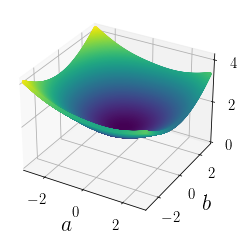

In [146]:
#i = 99
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(rr, ss, pp, s = 5, c = pp, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_zlim(0, 4.2)

(0.0, 4.2)

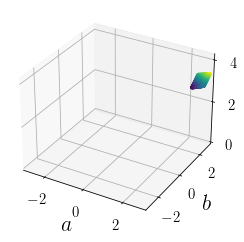

In [99]:
i = 99
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(grids[i][0], grids[i][1], bces[i], s = 5, c = bces[i], cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_zlim(0, 4.2)

(0.0, 4.2)

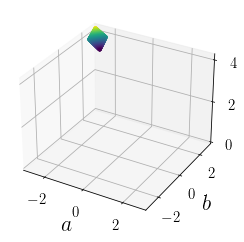

In [45]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(grids[0][0], grids[0][1], bces[0], s = 5, c = bces[0], cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_zlim(0, 4.2)

(0.0, 4.2)

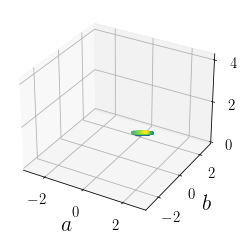

In [86]:
i = 99
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(grids[i][0], grids[i][1], bces[i], s = 5, c = bces[i], cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_zlim(0, 4.2)

In [87]:
aa, bb = np.meshgrid(np.linspace(-3, 3, 601), np.linspace(-3, 3, 601))

In [88]:
aa

array([[-3.  , -2.99, -2.98, ...,  2.98,  2.99,  3.  ],
       [-3.  , -2.99, -2.98, ...,  2.98,  2.99,  3.  ],
       [-3.  , -2.99, -2.98, ...,  2.98,  2.99,  3.  ],
       ...,
       [-3.  , -2.99, -2.98, ...,  2.98,  2.99,  3.  ],
       [-3.  , -2.99, -2.98, ...,  2.98,  2.99,  3.  ],
       [-3.  , -2.99, -2.98, ...,  2.98,  2.99,  3.  ]])

In [89]:
bb

array([[-3.  , -3.  , -3.  , ..., -3.  , -3.  , -3.  ],
       [-2.99, -2.99, -2.99, ..., -2.99, -2.99, -2.99],
       [-2.98, -2.98, -2.98, ..., -2.98, -2.98, -2.98],
       ...,
       [ 2.98,  2.98,  2.98, ...,  2.98,  2.98,  2.98],
       [ 2.99,  2.99,  2.99, ...,  2.99,  2.99,  2.99],
       [ 3.  ,  3.  ,  3.  , ...,  3.  ,  3.  ,  3.  ]])

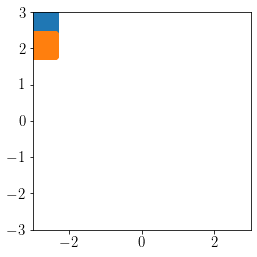

In [21]:
plt.scatter(grids[0][0], grids[0][1])
plt.scatter(grids[1][0], grids[1][1])
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.gca().set_aspect('equal')

In [31]:
grids[0][1].shape

(61, 60)

In [27]:
grids[8][1].shape

(60, 60)

In [24]:
grids[9][0]

array([[-3.  , -2.99, -2.98, ..., -2.43, -2.42, -2.41],
       [-3.  , -2.99, -2.98, ..., -2.43, -2.42, -2.41],
       [-3.  , -2.99, -2.98, ..., -2.43, -2.42, -2.41],
       ...,
       [-3.  , -2.99, -2.98, ..., -2.43, -2.42, -2.41],
       [-3.  , -2.99, -2.98, ..., -2.43, -2.42, -2.41],
       [-3.  , -2.99, -2.98, ..., -2.43, -2.42, -2.41]])

In [34]:
grids[9][0]

array([[-3.  , -2.99, -2.98, ..., -2.43, -2.42, -2.41],
       [-3.  , -2.99, -2.98, ..., -2.43, -2.42, -2.41],
       [-3.  , -2.99, -2.98, ..., -2.43, -2.42, -2.41],
       ...,
       [-3.  , -2.99, -2.98, ..., -2.43, -2.42, -2.41],
       [-3.  , -2.99, -2.98, ..., -2.43, -2.42, -2.41],
       [-3.  , -2.99, -2.98, ..., -2.43, -2.42, -2.41]])

In [35]:
grids[9][1]

array([[-3.  , -3.  , -3.  , ..., -3.  , -3.  , -3.  ],
       [-2.99, -2.99, -2.99, ..., -2.99, -2.99, -2.99],
       [-2.98, -2.98, -2.98, ..., -2.98, -2.98, -2.98],
       ...,
       [-2.43, -2.43, -2.43, ..., -2.43, -2.43, -2.43],
       [-2.42, -2.42, -2.42, ..., -2.42, -2.42, -2.42],
       [-2.41, -2.41, -2.41, ..., -2.41, -2.41, -2.41]])

In [38]:
bce(-2.98, -3)

4.0930679489073984

In [33]:
bce(grids[9][0], grids[9][1])

array([[4.10491326, 4.09898405, 4.09306795, ..., 3.789813  , 3.78473729,
        3.7796785 ],
       [4.0988974 , 4.09295611, 4.08702791, ..., 3.78306754, 3.77797837,
        3.7729061 ],
       [4.09289749, 4.08694413, 4.08100383, ..., 3.7763383 , 3.77123566,
        3.7661499 ],
       ...,
       [3.78859285, 3.78199751, 3.77541353, ..., 3.43278645, 3.42694946,
        3.42112793],
       [3.78354746, 3.77694096, 3.77034581, ..., 3.42705162, 3.42120157,
        3.41536695],
       [3.77852018, 3.77190256, 3.76529624, ..., 3.42133609, 3.41547299,
        3.40962528]])

In [154]:
bces, aa, bb = gridded(bce, -3, 3, 0.01, 10)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [155]:
bces.shape

(601, 601)

Text(0.5, 0.92, 'BCE Loss of $\\sigma(ax + b)$')

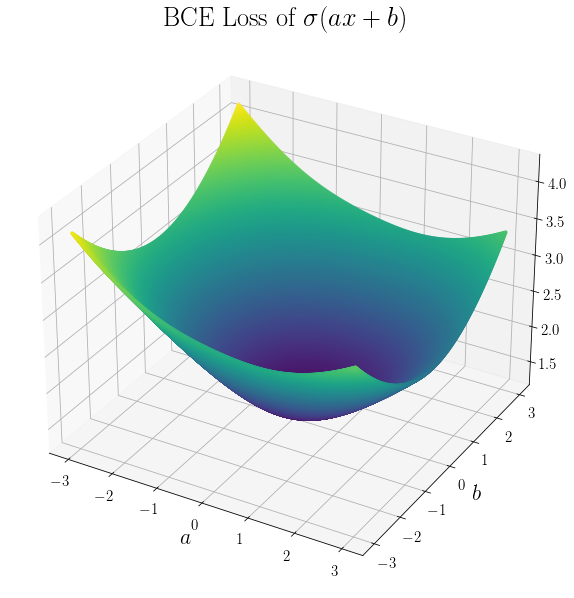

In [156]:
fig = plt.figure(figsize = (10, 20))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(aa, bb, bces, s = 5, c = bces, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_title(r'BCE Loss of $\sigma(ax + b)$')

# Basic Run

## Running

In [ ]:
np.save('anims/bces', bces)
np.save('anims/mses', mses)
np.save('anims/mlcs', mlcs)
np.save('anims/sqrs', sqrs)
np.save('anims/aa', aa)
np.save('anims/bb', bb)

## Examining

In [ ]:
aa = np.load('anims/aa.npy')
bb = np.load('anims/bb.npy')

bces = np.load('anims/bces.npy')
mses = np.load('anims/mses.npy')
mlcs = np.load('anims/mlcs.npy')
sqrs = np.load('anims/sqrs.npy')

nbces = np.load('anims/nbces.npy')
nmses = np.load('anims/nmses.npy')
nmlcs = np.load('anims/nmlcs.npy')
nsqrs = np.load('anims/nsqrs.npy')

In [ ]:
print('Empirical Estimation')
print(aa[bces == np.min(bces)], bb[bces == np.min(bces)])
print(aa[mses == np.min(mses)], bb[mses == np.min(mses)])
print(aa[mlcs == np.min(mlcs)], bb[mlcs == np.min(mlcs)])
print(aa[sqrs == np.min(sqrs)], bb[sqrs == np.min(sqrs)])
print()
print('Numerical Estimation')
print(aa[nbces == np.min(nbces)], bb[nbces == np.min(nbces)])
print(aa[nmses == np.min(nmses)], bb[nmses == np.min(nmses)])
print(aa[nmlcs == np.min(nmlcs)], bb[nmlcs == np.min(nmlcs)])
print(aa[nsqrs == np.min(nsqrs)], bb[nsqrs == np.min(nsqrs)])

# Plot All

In [ ]:
fig = plt.figure(figsize = (15, 30))
ax = fig.add_subplot(4, 2, 1, projection = '3d')
ax.scatter(xs, ys, bce_zs, s = 5, c = bce_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_title(r'BCE Loss of $\sigma(ax + b)$')

ax = fig.add_subplot(4, 2, 2)
ax.scatter(xs, ys, c = bce_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

ax = fig.add_subplot(4, 2, 3, projection = '3d')
ax.scatter(xs, ys, mse_zs, s = 5, c = mse_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_title(r'MSE Loss of $\sigma(ax + b)$')

ax = fig.add_subplot(4, 2, 4)
ax.scatter(xs, ys, c = mse_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

ax = fig.add_subplot(4, 2, 5, projection = '3d')
ax.scatter(xs, ys, mlc_zs, s = 5, c = mlc_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_title(r'MLC Loss of ${\rm ReLU}(ax + b)$')

ax = fig.add_subplot(4, 2, 6)
ax.scatter(xs, ys, c = mlc_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

ax = fig.add_subplot(4, 2, 7, projection = '3d')
ax.scatter(xs, ys, sqr_zs, s = 5, c = sqr_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_title(r'SQR Loss of ${\rm ReLU}(ax + b)$')

ax = fig.add_subplot(4, 2, 8)
ax.scatter(xs, ys, c = sqr_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

In [ ]:
nbce_zs = np.load('anims/nbce_zs.npy')
nmse_zs = np.load('anims/nmse_zs.npy')
nmlc_zs = np.load('anims/nmlc_zs.npy')
nsqr_zs = np.load('anims/nsqr_zs.npy')

In [ ]:
x_min = g[nbce_zs == min(nbce_zs)][:, 0]
y_min = g[nbce_zs == min(nbce_zs)][:, 1]
z_min = nbce_zs[nbce_zs == min(nbce_zs)]

In [ ]:
fig = plt.figure(figsize = (15, 30))
ax = fig.add_subplot(4, 2, 1, projection = '3d')
ax.scatter(xs, ys, nbce_zs, s = 5, c = nbce_zs, cmap = 'viridis')
ax.scatter(
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_title(r'BCE Loss of $\sigma(ax + b)$')

ax = fig.add_subplot(4, 2, 2)
ax.scatter(xs, ys, c = nbce_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

ax = fig.add_subplot(4, 2, 3, projection = '3d')
ax.scatter(xs, ys, nmse_zs, s = 5, c = nmse_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_title(r'MSE Loss of $\sigma(ax + b)$')

ax = fig.add_subplot(4, 2, 4)
ax.scatter(xs, ys, c = nmse_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

ax = fig.add_subplot(4, 2, 5, projection = '3d')
ax.scatter(xs, ys, nmlc_zs, s = 5, c = nmlc_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_title(r'MLC Loss of ${\rm ReLU}(ax + b)$')

ax = fig.add_subplot(4, 2, 6)
ax.scatter(xs, ys, c = nmlc_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

ax = fig.add_subplot(4, 2, 7, projection = '3d')
ax.scatter(xs, ys, nsqr_zs, s = 5, c = nsqr_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_title(r'SQR Loss of ${\rm ReLU}(ax + b)$')

ax = fig.add_subplot(4, 2, 8)
ax.scatter(xs, ys, c = nsqr_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

# Rotating Plots

In [ ]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, projection = '3d')

def init():
    ax.scatter(xs, ys, bce_zs, s = 5, c = bce_zs, cmap = 'viridis')
    plt.xlabel(r'$a$')
    plt.ylabel(r'$b$')
    plt.title(r'BCE Loss of $\sigma(ax + b)$')
    return fig,

def animate(i):
    ax.view_init(elev=30., azim=3.6*i)
    return fig,

ani = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=100, blit=False)  
ani.save('anims/bce_2.gif')

In [ ]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, projection = '3d')

def init():
    ax.scatter(xs, ys, mse_zs, s = 5, c = mse_zs, cmap = 'viridis')
    plt.xlabel(r'$a$')
    plt.ylabel(r'$b$')
    plt.title(r'MSE Loss of $\sigma(ax + b)$')
    return fig,

def animate(i):
    ax.view_init(elev=30., azim=3.6*i)
    return fig,

ani = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=100, blit=True)  
ani.save('anims/mse.gif')

In [ ]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, projection = '3d')

def init():
    ax.scatter(xs, ys, mlc_zs, s = 5, c = mlc_zs, cmap = 'viridis')
    plt.xlabel(r'$a$')
    plt.ylabel(r'$b$')
    plt.title(r'MLC Loss of ReLU$(ax + b)$')
    return fig,

def animate(i):
    ax.view_init(elev=30., azim=3.6*i)
    return fig,

ani = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=100, blit=True)  
ani.save('anims/mlc.gif')

In [ ]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, projection = '3d')

def init():
    ax.scatter(xs, ys, sqr_zs, s = 5, c = sqr_zs, cmap = 'viridis')
    plt.xlabel(r'$a$')
    plt.ylabel(r'$b$')
    plt.title(r'SQR Loss of ReLU$(ax + b)$')
    return fig,

def animate(i):
    ax.view_init(elev=30., azim=3.6*i)
    return fig,

ani = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=100, blit=True)  
ani.save('anims/sqr.gif')

# Static Plots

In [ ]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(projection = '3d')
ax.scatter(xs, ys, bce_zs, s = 5, c = bce_zs, cmap = 'viridis')
plt.xlabel(r'$a$')
plt.ylabel(r'$b$')
plt.title(r'BCE Loss of $\sigma(ax + b)$')

#plt.savefig('plots/scratch/bce_landscape_100.png',
#            dpi=1200, 
#            bbox_inches='tight')

In [ ]:
plt.figure(figsize = (8, 8))
plt.scatter(xs, ys, c = bce_zs, cmap='viridis')
plt.xlabel(r'$a$')
plt.ylabel(r'$b$')
plt.gca().set_aspect('equal')
plt.title(r'BCE Loss of $\sigma(ax + b)$')

plt.savefig('plots/scratch/bce_landscape_100_flat.png',
            dpi=1200, 
            bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(projection = '3d')
ax.scatter(xs, ys, mse_zs, s = 5, c = mse_zs, cmap = 'viridis')
plt.xlabel(r'$a$')
plt.ylabel(r'$b$')
plt.title(r'MSE Loss of $\sigma(ax + b)$')

plt.savefig('plots/scratch/mse_landscape_100.png',
            dpi=1200, 
            bbox_inches='tight')

In [ ]:
plt.figure(figsize = (8, 8))
plt.scatter(xs, ys, c = mse_zs, cmap='viridis')
plt.xlabel(r'$a$')
plt.ylabel(r'$b$')
plt.gca().set_aspect('equal')
plt.title(r'MSE Loss of $\sigma(ax + b)$')

plt.savefig('plots/scratch/mse_landscape_100_flat.png',
            dpi=1200, 
            bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(projection = '3d')
ax.scatter(xs, ys, mlc_zs, c = mlc_zs, cmap = 'viridis')
plt.xlabel(r'$a$')
plt.ylabel(r'$b$')
plt.title(r'MLC Loss of ReLU$(ax + b)$')

plt.savefig('plots/scratch/mlc_landscape_100.png',
            dpi=1200, 
            bbox_inches='tight')

In [ ]:
plt.figure(figsize = (8, 8))
plt.scatter(xs, ys, c = mlc_zs, cmap='viridis')
plt.xlabel(r'$a$')
plt.ylabel(r'$b$')
plt.gca().set_aspect('equal')
plt.title(r'MLC Loss of ReLU$(ax + b)$')

plt.savefig('plots/scratch/mlc_landscape_100_flat.png',
            dpi=1200, 
            bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(projection = '3d')
ax.scatter(xs, ys, sqr_zs, c = sqr_zs, cmap = 'viridis')
plt.xlabel(r'$a$')
plt.ylabel(r'$b$')
plt.title(r'SQR Loss of ReLU$(ax + b)$')

plt.savefig('plots/scratch/sqr_landscape_100.png',
            dpi=1200, 
            bbox_inches='tight')

In [ ]:
plt.figure(figsize = (8, 8))
plt.scatter(xs, ys, c = sqr_zs, cmap='viridis')
plt.xlabel(r'$a$')
plt.ylabel(r'$b$')
plt.gca().set_aspect('equal')
plt.title(r'SQR Loss of ReLU$(ax + b)$')

plt.savefig('plots/scratch/sqr_landscape_100_flat.png',
            dpi=1200, 
            bbox_inches='tight')

# Shifting Gaussians

## BCE

In [ ]:
ms = np.arange(0.1, 1.01, 0.01)
N = 5 * 10**4

i = 0
for m in ms:
    bkgd = stats.norm.rvs(-m, 1, size = N)
    sgnl = stats.norm.rvs(+m, 1, size = N)
    X = np.concatenate((bkgd, sgnl))
    y = np.concatenate((np.zeros(N), np.ones(N)))

    xs = g[:, 0]
    ys = g[:, 1]
    zs = []
    for p in g:
        zs += [bce(p[0], p[1])]

    fig = plt.figure(figsize = (8, 8))
    ax = fig.add_subplot(111, projection = '3d')
    ax.scatter(xs, ys, zs, s = 5, c = zs, cmap = 'viridis')
    ax.set_zlim(0, 10)
    plt.savefig('anims/shift/{}.png'.format(i),
                dpi=1200, 
                bbox_inches='tight')
    i += 1

## MSE

In [ ]:
ms = np.arange(0.1, 1.01, 0.01)
N = 5 * 10**4

i = 0
for m in ms:
    bkgd = stats.norm.rvs(-m, 1, size = N)
    sgnl = stats.norm.rvs(+m, 1, size = N)
    X = np.concatenate((bkgd, sgnl))
    y = np.concatenate((np.zeros(N), np.ones(N)))

    xs = g[:, 0]
    ys = g[:, 1]
    zs = []
    for p in g:
        zs += [mse(p[0], p[1])]

    fig = plt.figure(figsize = (8, 8))
    ax = fig.add_subplot(111, projection = '3d')
    ax.scatter(xs, ys, zs, s = 5, c = zs, cmap = 'viridis')
    ax.set_zlim(0.2, 1)
    plt.savefig('anims/shift/mse/{}.png'.format(i),
                dpi=1200, 
                bbox_inches='tight')
    fig.clear()
    plt.close(fig)
    i += 1

## MLC

In [ ]:
ms = np.arange(0.1, 1.01, 0.01)
N = 5 * 10**4

i = 0
for m in ms:
    bkgd = stats.norm.rvs(-m, 1, size = N)
    sgnl = stats.norm.rvs(+m, 1, size = N)
    X = np.concatenate((bkgd, sgnl))
    y = np.concatenate((np.zeros(N), np.ones(N)))

    xs = g[:, 0]
    ys = g[:, 1]
    zs = []
    for p in g:
        zs += [mlc(p[0], p[1])]

    fig = plt.figure(figsize = (8, 8))
    ax = fig.add_subplot(111, projection = '3d')
    ax.scatter(xs, ys, zs, s = 5, c = zs, cmap = 'viridis')
    ax.set_zlim(0, 38)
    plt.savefig('anims/shift/mlc/{}.png'.format(i),
                dpi=1200, 
                bbox_inches='tight')
    fig.clear()
    plt.close(fig)
    i += 1

## SQR

In [ ]:
ms = np.arange(0.1, 1.01, 0.01)
N = 5 * 10**4

i = 0
for m in ms:
    bkgd = stats.norm.rvs(-m, 1, size = N)
    sgnl = stats.norm.rvs(+m, 1, size = N)
    X = np.concatenate((bkgd, sgnl))
    y = np.concatenate((np.zeros(N), np.ones(N)))

    xs = g[:, 0]
    ys = g[:, 1]
    zs = []
    for p in g:
        zs += [sqr(p[0], p[1])]

    fig = plt.figure(figsize = (8, 8))
    ax = fig.add_subplot(111, projection = '3d')
    ax.scatter(xs, ys, zs, s = 5, c = zs, cmap = 'viridis')
    ax.set_zlim(0, 70000000)
    plt.savefig('anims/shift/sqr/{}.png'.format(i),
                dpi=1200, 
                bbox_inches='tight')
    fig.clear()
    plt.close(fig)
    i += 1

# $A/B$ Parametrizations

## MSE

In [ ]:
ps = np.arange(-2, 2, 0.05)
N = 5 * 10**4

i = 0
for p in ps:
    bkgd = stats.norm.rvs(-1, 1, size = N)
    sgnl = stats.norm.rvs(+1, 1, size = N)
    X = np.concatenate((bkgd, sgnl))
    y = np.concatenate((np.zeros(N), np.ones(N)))

    xs = g[:, 0]
    ys = g[:, 1]
    zs = []
    for pt in g:
        zs += [mse_p(pt[0], pt[1], p)]

    fig = plt.figure(figsize = (8, 8))
    ax = fig.add_subplot(111, projection = '3d')
    ax.scatter(xs, ys, zs, s = 5, c = zs, cmap = 'viridis')
    ax.set_zlim(0.2, 5)
    plt.savefig('anims/mse_ab/{}.png'.format(i),
                dpi=1200, 
                bbox_inches='tight')
    fig.clear()
    plt.close(fig)
    i += 1

## SQR

In [ ]:
rs = np.arange(-2, 2, 0.05)
N = 5 * 10**4

i = 0
for r in rs:
    bkgd = stats.norm.rvs(-1, 1, size = N)
    sgnl = stats.norm.rvs(+1, 1, size = N)
    X = np.concatenate((bkgd, sgnl))
    y = np.concatenate((np.zeros(N), np.ones(N)))

    xs = g[:, 0]
    ys = g[:, 1]
    zs = []
    for pt in g:
        zs += [sqr_r(pt[0], pt[1], r)]

    fig = plt.figure(figsize = (8, 8))
    ax = fig.add_subplot(111, projection = '3d')
    ax.scatter(xs, ys, zs, s = 5, c = zs, cmap = 'viridis')
    ax.set_xlim(-7, 7)
    ax.set_ylim(-7, 7)
    ax.set_zlim(0, 70000000)
    plt.savefig('anims/sqr_ab/{}.png'.format(i),
                dpi=1200, 
                bbox_inches='tight')
    fig.clear()
    plt.close(fig)
    i += 1

# $C$ Parametrizations

## MLC

In [ ]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, projection = '3d')

def init():
    ax.scatter(xs, ys, exp_mlc_zs, s = 5, c = exp_mlc_zs, cmap = 'viridis')
    ax.set_zlim(0, 10)
    plt.xlabel(r'$a$')
    plt.ylabel(r'$b$')
    plt.title(r'Exp MLC Loss of ReLU$(ax + b)$')
    return fig,

def animate(i):
    ax.view_init(elev=30., azim=3.6*i)
    return fig,

ani = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=100, blit=True)  
ani.save('anims/exp_mlc_2.gif')

## SQR

In [ ]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, projection = '3d')

def init():
    ax.scatter(xs, ys, exp_sqr_zs, s = 5, c = exp_sqr_zs, cmap = 'viridis')
    ax.set_zlim(1.5, 6)
    plt.xlabel(r'$a$')
    plt.ylabel(r'$b$')
    plt.title(r'Exp SQR Loss of ReLU$(ax + b)$')
    return fig,

def animate(i):
    ax.view_init(elev=30., azim=3.6*i)
    return fig,

ani = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=100, blit=True)  
ani.save('anims/exp_sqr_2.gif')

# Gamma Landscapes

In [ ]:
N = 5 * 10**3
bkgd = stats.gamma.rvs(5, 1, size = N)
sgnl = stats.gamma.rvs(6, 1, size = N)
X = np.concatenate((bkgd, sgnl))
y = np.concatenate((np.zeros(N), np.ones(N)))

In [ ]:
%%time

xs = g[:, 0]
ys = g[:, 1]
bce_zs = []
mse_zs = []
mlc_zs = []
sqr_zs = []
i = 0
for p in g:
    bce_zs += [bce(p[0], p[1])]
    mse_zs += [mse(p[0], p[1])]
    mlc_zs += [mlc(p[0], p[1])]
    sqr_zs += [sqr(p[0], p[1])]
    if i % 100 == 0:
        print(i, ':', bce_zs[-1], mse_zs[-1], mlc_zs[-1], sqr_zs[-1]) 
    i += 1

In [ ]:
fig = plt.figure(figsize = (16, 15))
ax = fig.add_subplot(2, 2, 1, projection = '3d')
ax.scatter(xs, ys, bce_zs, s = 5, c = bce_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')


ax = fig.add_subplot(2, 2, 2)
ax.scatter(xs, ys, c = bce_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

fig.suptitle(r'BCE Loss of $\sigma(ax + b)$', y = 0.92)
plt.savefig('plots/bce_gammas.png', 
            dpi=1200, 
            bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize = (16, 15))
ax = fig.add_subplot(2, 2, 1, projection = '3d')
ax.scatter(xs, ys, mse_zs, s = 5, c = mse_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')


ax = fig.add_subplot(2, 2, 2)
ax.scatter(xs, ys, c = mse_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

fig.suptitle(r'MSE Loss of $\sigma(ax + b)$', y = 0.92)
plt.savefig('plots/mse_gammas.png', 
            dpi=1200, 
            bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize = (16, 15))
ax = fig.add_subplot(2, 2, 1, projection = '3d')
ax.scatter(xs, ys, mlc_zs, s = 5, c = mlc_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')


ax = fig.add_subplot(2, 2, 2)
ax.scatter(xs, ys, c = mlc_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

fig.suptitle(r'MLC Loss of ReLU$(ax + b)$', y = 0.92)
plt.savefig('plots/mlc_gammas.png', 
            dpi=1200, 
            bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize = (16, 15))
ax = fig.add_subplot(2, 2, 1, projection = '3d')
ax.scatter(xs, ys, sqr_zs, s = 5, c = sqr_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')


ax = fig.add_subplot(2, 2, 2)
ax.scatter(xs, ys, c = sqr_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

fig.suptitle(r'SQR Loss of ReLU$(ax + b)$', y = 0.92)
plt.savefig('plots/sqr_gammas.png', 
            dpi=1200, 
            bbox_inches='tight')

# Betas

In [ ]:
N = 5 * 10**3
bkgd = stats.beta.rvs(2, 3, size = N)
sgnl = stats.beta.rvs(3, 2, size = N)
X = np.concatenate((bkgd, sgnl))
y = np.concatenate((np.zeros(N), np.ones(N)))

g = np.meshgrid(np.linspace(-2, 2, 200), np.linspace(-2, 2, 200))
g = np.append(g[0].reshape(-1,1),g[1].reshape(-1,1),axis = 1)

In [ ]:
%%time

xs = g[:, 0]
ys = g[:, 1]
bce_zs = []
mse_zs = []
mlc_zs = []
sqr_zs = []
i = 0
for p in g:
    bce_zs += [bce(p[0], p[1])]
    mse_zs += [mse(p[0], p[1])]
    mlc_zs += [mlc(p[0], p[1])]
    sqr_zs += [sqr(p[0], p[1])]
    if i % 100 == 0:
        print(i, ':', bce_zs[-1], mse_zs[-1], mlc_zs[-1], sqr_zs[-1]) 
    i += 1

In [ ]:
fig = plt.figure(figsize = (16, 15))
ax = fig.add_subplot(2, 2, 1, projection = '3d')
ax.scatter(xs, ys, bce_zs, s = 5, c = bce_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')


ax = fig.add_subplot(2, 2, 2)
ax.scatter(xs, ys, c = bce_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

fig.suptitle(r'BCE Loss of $\sigma(ax + b)$', y = 0.92)
plt.savefig('plots/bce_betas.png', 
            dpi=1200, 
            bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize = (16, 15))
ax = fig.add_subplot(2, 2, 1, projection = '3d')
ax.scatter(xs, ys, mse_zs, s = 5, c = mse_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')


ax = fig.add_subplot(2, 2, 2)
ax.scatter(xs, ys, c = mse_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

fig.suptitle(r'MSE Loss of $\sigma(ax + b)$', y = 0.92)
plt.savefig('plots/mse_betas.png', 
            dpi=1200, 
            bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize = (16, 15))
ax = fig.add_subplot(2, 2, 1, projection = '3d')
ax.scatter(xs, ys, mlc_zs, s = 5, c = mlc_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')


ax = fig.add_subplot(2, 2, 2)
ax.scatter(xs, ys, c = mlc_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

fig.suptitle(r'MLC Loss of ReLU$(ax + b)$', y = 0.92)
plt.savefig('plots/mlc_betas.png', 
            dpi=1200, 
            bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize = (16, 15))
ax = fig.add_subplot(2, 2, 1, projection = '3d')
ax.scatter(xs, ys, sqr_zs, s = 5, c = sqr_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')


ax = fig.add_subplot(2, 2, 2)
ax.scatter(xs, ys, c = sqr_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

fig.suptitle(r'SQR Loss of ReLU$(ax + b)$', y = 0.92)
plt.savefig('plots/sqr_betas.png', 
            dpi=1200, 
            bbox_inches='tight')

# Scratch

In [ ]:
import numpy as np
from scipy import stats
from scipy import integrate
import matplotlib.pyplot as plt

In [ ]:
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(+0.1, 1)
#eps = np.finfo(float).eps
eps = 1e-7

In [ ]:
def sig(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

In [ ]:
# Numerical estimation of losses

bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(+0.1, 1)

@np.vectorize
def nbce(a, b):
    g = lambda x: -(sgnl.pdf(x) * np.log(sig(a*x + b) + eps) + \
                    bkgd.pdf(x) * np.log(1 - sig(a*x + b) + eps) )
    return integrate.quad(g, -np.inf, np.inf)[0]

@np.vectorize
def nmse(a, b):
    g = lambda x: -(sgnl.pdf(x) * -(1 - sig(a*x + b))**2 + \
                    bkgd.pdf(x) * -(sig(a*x + b)**2) )
    return integrate.quad(g, -np.inf, np.inf)[0]

@np.vectorize
def nmlc(a, b):
    g = lambda x: -(sgnl.pdf(x) * np.log(relu(a*x + b) + eps) + \
                    bkgd.pdf(x) * (1 - relu(a*x + b)) )
    return integrate.quad(g, -np.inf, np.inf)[0]

@np.vectorize
def nsqr(a, b):
    g = lambda x: -(sgnl.pdf(x) * -1 / (relu(a*x + b) + eps)**0.5 + \
                    bkgd.pdf(x) * -relu(a*x + b)**0.5 )
    return integrate.quad(g, -np.inf, np.inf)[0]

def vbce(a, b):
    g = lambda x: -(sgnl.pdf(x) * np.log(sig(a*x + b) + eps) + \
                    bkgd.pdf(x) * np.log(1 - sig(a*x + b) + eps) )
    return integrate.quad_vec(g, -np.inf, np.inf)[0]

def vmse(a, b):
    g = lambda x: -(sgnl.pdf(x) * -(1 - sig(a*x + b))**2 + \
                    bkgd.pdf(x) * -(sig(a*x + b)**2) )
    return integrate.quad_vec(g, -np.inf, np.inf)[0]

def vmlc(a, b):
    g = lambda x: -(sgnl.pdf(x) * np.log(relu(a*x + b) + eps) + \
                    bkgd.pdf(x) * (1 - relu(a*x + b)) )
    return integrate.quad_vec(g, -np.inf, np.inf)[0]

def vsqr(a, b):
    g = lambda x: -(sgnl.pdf(x) * -1 / (relu(a*x + b) + eps)**0.5 + \
                    bkgd.pdf(x) * -relu(a*x + b)**0.5 )
    return integrate.quad_vec(g, -np.inf, np.inf)[0]

In [ ]:
aa, bb = np.meshgrid(np.linspace(-1.5, 1.5, 21), np.linspace(-1.5, 1.5, 21))

In [ ]:
vvc = vbce(aa, bb)
vvs = vmse(aa, bb)
vvl = vmlc(aa, bb)
vvq = vsqr(aa, bb)

In [ ]:
nnc = nbce(aa, bb)
nns = nmse(aa, bb)
nnl = nmlc(aa, bb)
nnq = nsqr(aa, bb)

In [ ]:
np.max(vvc - nnc), np.max(vvs - nns), np.max(vvl - nnl), np.max(vvq - nnq)

# The Issue


In [ ]:
eps = np.finfo(float).eps

In [ ]:
fa = 0.19
fb = 1.02
f = lambda x: -(sgnl.pdf(x) * -1 / (relu(fa*x + fb) + eps)**0.5 + \
                bkgd.pdf(x) * -relu(fa*x + fb)**0.5 )

In [ ]:
ha = 0.15
hb = 1.02
h = lambda x: -(sgnl.pdf(x) * -1 / (relu(ha*x + hb) + eps)**0.5 + \
                bkgd.pdf(x) * -relu(ha*x + hb)**0.5 )

In [ ]:
xs = np.linspace(-7, 7, 1000)
plt.plot(xs, f(xs), label = 'f')
plt.plot(xs, h(xs), label = 'h')
plt.legend();

In [ ]:
-hb / ha

In [ ]:
-fb / fa

In [ ]:
x = xs[f(xs) == np.max(f(xs))]

In [ ]:
x

In [ ]:
sgnl.pdf(x)

In [ ]:
1 / (relu(ha*x + hb) + eps)**0.5

In [ ]:
1 / (relu(fa*x + fb) + eps)**0.5

In [ ]:
eps = 1e-11

In [ ]:
xs = np.linspace(-7, 7, 1000)
plt.plot(xs, f(xs), label = 'f')
plt.plot(xs, h(xs), label = 'h')
plt.legend();

# Vectorization

## Method 1: Numpy Vectorization

A one-dimensional example.

In [ ]:
fun2int = lambda x, a: np.sqrt(x+a)
intfun = lambda a: integrate.quad(fun2int, 0, 4, args=(a))[0]
vec_int = np.vectorize(intfun)
vec_int(np.linspace(0,2,5))

While this doesn't speed up performance, it is convenient. It also allows for interval modifying based on the input.

In [ ]:
j = lambda x, a, b: -(sgnl.pdf(x) * -1 / (relu(a*x + b) + eps)**0.5 + \
                      bkgd.pdf(x) * -relu(a*x + b)**0.5 )
t = lambda a, b: integrate.quad(j, a == 0 and -np.inf or -b/a, np.inf, args=(a, b))[0]
vec_t = np.vectorize(t)

In [ ]:
vec_t([-1, 0, 1], [0, 1, 2])

In [ ]:
vec_t([-1, 0, 1], 0)

In [ ]:
vec_t([-1, 0, 1], 1)

In [ ]:
vec_t([-1, 0, 1], 2)

In [ ]:
vec_t([[-1, 0, 1], [-1, 0, 1]], [[-1, -1, -1], [0, 0, 0]])

In [ ]:
X, Y = np.meshgrid(np.linspace(-1.5, 1.5, 11), np.linspace(-1.5, 1.5, 11))
#g = np.round(np.append(g[0].reshape(-1, 1), g[1].reshape(-1, 1), axis = 1), 3)

In [ ]:
plt.contour(X, Y, vec_t(X, Y))

## Method 2: quad_vec

This results in a speed-up, but it doesn't allow us to modify the interval based on the values of $a$ and $b$. We would have to tune epsilon instead.

In [ ]:
np.array([[a, b] for a in [-1, 0, 1] for b in [-1, 0, 1]]).reshape(-1)

In [ ]:
aa = [-1, 0, 1]
bb = [-1, 0, 1]
f = lambda x: np.array([bkgd.pdf(x) * -relu(a*x + b)**0.5 for a in aa for b in bb])

In [ ]:
integrate.quad_vec(f, -np.inf, np.inf)

In [ ]:
a, b = np.meshgrid([-1, 0, 1], [-1, 0, 1])
f = lambda x: 1 / (1 + np.exp(a*x**2 + b))

In [ ]:
f(1)

In [ ]:
integrate.quad_vec(f, -np.inf, np.inf)

In [ ]:
(bkgd.pdf(1) + relu(a*1 + b)).reshape(-1).reshape(a.shape)

In [ ]:
a, b = np.meshgrid([-1, 0.19, 1], [-1, 1.02, 1])
g = lambda x: -(sgnl.pdf(x) * -1 / (relu(a*x + b) + eps)**0.5 + \
                bkgd.pdf(x) * -relu(a*x + b)**0.5 )

In [ ]:
g(0)

This appears to vectorize properly, but since we can't have special integral bounds, suffers from that issue instead.

In [ ]:
eps = np.finfo(float).eps

In [ ]:
integrate.quad_vec(g, -np.inf, np.inf)

In [ ]:
np.minimum(-b/a, -np.inf).reshape(-1)